In [ ]:
!pip -q install opencv-python numpy

In [ ]:
import os
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:

uploaded = files.upload()
assert len(uploaded) > 0, "No file selected."
image_path = list(uploaded.keys())[0]
print("Using image:", image_path)


img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
assert img is not None, "Could not read the uploaded image."
print("Image shape:", img.shape)


Saving morph_texture_test.png to morph_texture_test (1).png
Using image: morph_texture_test (1).png
Image shape: (512, 512)


In [ ]:
def get_kernel_rect_5():
    return cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

def get_kernel_ellipse_5():
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

def get_kernel_cross_5():
    return cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))

def get_kernel_diamond_5():

    k = np.zeros((5,5), dtype=np.uint8)
    for r in range(5):
        for c in range(5):
            if abs(r-2) + abs(c-2) <= 2:
                k[r, c] = 1
    return k

kernels = {
    "rect": get_kernel_rect_5(),
    "ellipse": get_kernel_ellipse_5(),
    "cross": get_kernel_cross_5(),
    "diamond": get_kernel_diamond_5(),
}


for name, k in kernels.items():
    print(name, "\n", k)


rect 
 [[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
ellipse 
 [[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]]
cross 
 [[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]
diamond 
 [[0 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 0 0]]


In [ ]:
def pad_for_kernel(img: np.ndarray, kshape, pad_type: str = 'edge'):
    kh, kw = kshape
    ph, pw = kh // 2, kw // 2
    border_map = {
        'edge': cv2.BORDER_REPLICATE,
        'reflect': cv2.BORDER_REFLECT,
        'constant': cv2.BORDER_CONSTANT
    }
    return cv2.copyMakeBorder(img, ph, ph, pw, pw, border_map[pad_type])

def erode_from_scratch(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    kh, kw = kernel.shape
    padded = pad_for_kernel(img, (kh, kw))
    out = np.empty_like(img)
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            window = padded[r:r+kh, c:c+kw]
            vals = window[kernel == 1]
            out[r, c] = np.min(vals)
    return out

def dilate_from_scratch(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    kh, kw = kernel.shape
    padded = pad_for_kernel(img, (kh, kw))
    out = np.empty_like(img)
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            window = padded[r:r+kh, c:c+kw]
            vals = window[kernel == 1]
            out[r, c] = np.max(vals)
    return out

def opening_from_scratch(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    return dilate_from_scratch(erode_from_scratch(img, kernel), kernel)

def closing_from_scratch(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    return erode_from_scratch(dilate_from_scratch(img, kernel), kernel)

def tophat_from_scratch(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    opened = opening_from_scratch(img, kernel)
    return cv2.subtract(img, opened)

def blackhat_from_scratch(img: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    closed = closing_from_scratch(img, kernel)
    return cv2.subtract(closed, img)


In [ ]:
def cv_erode(img, kernel):    return cv2.erode(img, kernel, iterations=1)
def cv_dilate(img, kernel):   return cv2.dilate(img, kernel, iterations=1)
def cv_open(img, kernel):     return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
def cv_close(img, kernel):    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
def cv_tophat(img, kernel):   return cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
def cv_blackhat(img, kernel): return cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)

def assert_equal(a: np.ndarray, b: np.ndarray, name: str):
    if not np.array_equal(a, b):
        diff = (a.astype(np.int16) - b.astype(np.int16)) != 0
        pct = 100.0 * diff.sum() / diff.size
        raise AssertionError(f"[{name}] mismatch: {pct:.4f}% pixels differ")


In [ ]:
out_dir = "/content/morph_out"
os.makedirs(out_dir, exist_ok=True)

cv2.imwrite(os.path.join(out_dir, "000_original.png"), img)

operations = [
    ("erosion",   cv_erode,    erode_from_scratch),
    ("dilation",  cv_dilate,   dilate_from_scratch),
    ("opening",   cv_open,     opening_from_scratch),
    ("closing",   cv_close,    closing_from_scratch),
    ("tophat",    cv_tophat,   tophat_from_scratch),
    ("blackhat",  cv_blackhat, blackhat_from_scratch),
]

for kname, kernel in kernels.items():

    cv2.imwrite(os.path.join(out_dir, f"kernel_{kname}.png"), kernel.astype(np.uint8)*255)

    for opname, cv_impl, sc_impl in operations:
        cv_out = cv_impl(img, kernel)
        sc_out = sc_impl(img, kernel)


        cv_path = os.path.join(out_dir, f"{kname}_{opname}_opencv.png")
        sc_path = os.path.join(out_dir, f"{kname}_{opname}_scratch.png")
        cv2.imwrite(cv_path, cv_out)
        cv2.imwrite(sc_path, sc_out)


        assert_equal(cv_out, sc_out, f"{kname}/{opname}")

print("All operations completed. Outputs saved to:", out_dir)


All operations completed. Outputs saved to: /content/morph_out


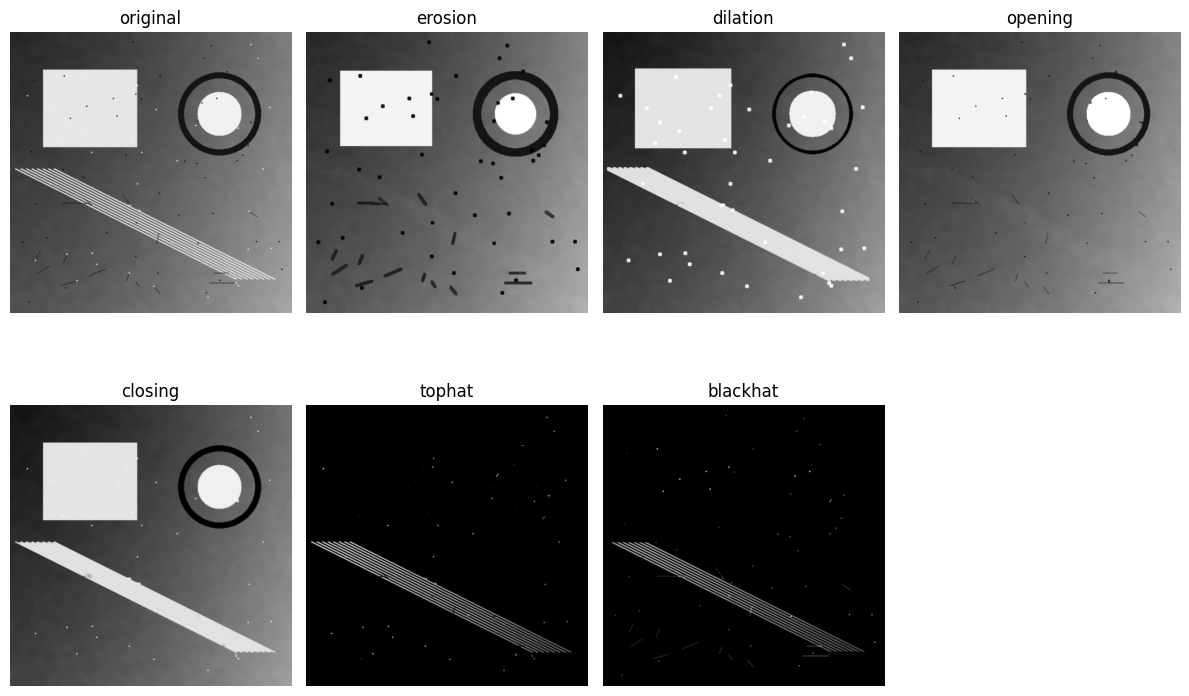

In [ ]:

kernel_name = "rect"
ops = ["erosion", "dilation", "opening", "closing", "tophat", "blackhat"]

plt.figure(figsize=(12, 8))
plt.subplot(2, 4, 1)
plt.title("original")
plt.axis('off')
plt.imshow(img, cmap='gray')

for i, op in enumerate(ops, start=2):
    res = cv2.imread(f"/content/morph_out/{kernel_name}_{op}_opencv.png", cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 4, i)
    plt.title(op)
    plt.axis('off')
    plt.imshow(res, cmap='gray')

plt.tight_layout()
plt.show()
